## 12-31-2025

# Module 2: Feature Extraction 

**Purpose:**
Extract fragmentomics and methylation features using gold-standard methods.

**UPDATED: Now extracts ALL 256 4-mer proportions** (not just top 20)

### Fragmentomics (~745 features)
1. **Fragment size** (20 features)
   - Summary stats: mean, median, std, quartiles, skewness, kurtosis, CV
   - Ratios: short/long, mono/di-nucleosomal
   
2. **Fragment size categories** (5 features)
   - % in each category

3. **End motifs** (258 features) **← UPDATED!**
   - **ALL 256 4-mer proportions** (kmer_AAAA, kmer_AAAT, ..., kmer_TTTT)
   - Motif diversity (Shannon entropy)
   - GC content
   
4. **Coverage profile** (468 features)
   - % of fragments per 100 kb bin across chr21

### Methylation (~475 features)
1. **Global methylation** (8 features)
2. **Regional methylation** (467 features)

**Total: ~1,220 features**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import Module 2 functions
from src.feature_extraction import (
    get_chromosome_length,
    extract_fragmentomics_features,
    extract_methylation_features,
    run_module_2
)

# Import config
from src.config import (
    SAMPLE_MANIFEST,
    ALL_FEATURES,
    FRAGMENTOMICS_FEATURES,
    METHYLATION_FEATURES_FILE,
    CHROMOSOME,
    FRAGMENTOMICS_BIN_SIZE,
    METHYLATION_BIN_SIZE,
    MIN_CPG_PER_BIN,
    KMER_SIZE,
    EXTRACT_ALL_KMERS
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful!")
print(f"\nConfiguration:")
print(f"  Chromosome: {CHROMOSOME}")
print(f"  Fragmentomics bin size: {FRAGMENTOMICS_BIN_SIZE:,} bp")
print(f"  Methylation bin size: {METHYLATION_BIN_SIZE:,} bp")
print(f"  Min CpG per bin: {MIN_CPG_PER_BIN}")
print(f"  K-mer size: {KMER_SIZE}")

✓ Imports successful!

Configuration:
  Chromosome: chr21
  Fragmentomics bin size: 100,000 bp
  Methylation bin size: 100,000 bp
  Min CpG per bin: 20
  K-mer size: 4


In [2]:
# Load manifest
manifest = pd.read_csv(SAMPLE_MANIFEST)
first_bam = manifest.iloc[0]['bam_path']

# Get chromosome length
import math
chr_length = get_chromosome_length(first_bam, CHROMOSOME)

# Calculate expected bins
n_frag_bins = math.ceil(chr_length / FRAGMENTOMICS_BIN_SIZE)
n_meth_bins = math.ceil(chr_length / METHYLATION_BIN_SIZE)

# Calculate expected k-mers
n_kmers = 4 ** KMER_SIZE if EXTRACT_ALL_KMERS else 20

print(f"Chromosome {CHROMOSOME}:")
print(f"  Length: {chr_length:,} bp")
print(f"\nExpected bins:")
print(f"  Fragmentomics (coverage): {n_frag_bins} bins")
print(f"  Methylation (regional): {n_meth_bins} bins")
print(f"\nExpected k-mers:")
print(f"  All 4-mers: {n_kmers} k-mers")
print(f"\nExpected feature counts:")
print(f"  Fragment size features: 20")
print(f"  Fragment categories: 5")
print(f"  K-mer proportions: {n_kmers}")
print(f"  Motif summary: 2")
print(f"  Coverage bins: {n_frag_bins}")
print(f"  Global methylation: 8")
print(f"  Regional methylation bins: {n_meth_bins}")
print(f"  Total: ~{20 + 5 + n_kmers + 2 + n_frag_bins + 8 + n_meth_bins:,}")

Chromosome chr21:
  Length: 46,709,983 bp

Expected bins:
  Fragmentomics (coverage): 468 bins
  Methylation (regional): 468 bins

Expected k-mers:
  All 4-mers: 256 k-mers

Expected feature counts:
  Fragment size features: 20
  Fragment categories: 5
  K-mer proportions: 256
  Motif summary: 2
  Coverage bins: 468
  Global methylation: 8
  Regional methylation bins: 468
  Total: ~1,227


## Run Module 2 - Extract All Features

This will extract all features from all 22 samples.

In [3]:
# Run complete Module 2 pipeline
fragmentomics_df, methylation_df, all_features_df = run_module_2()


MODULE 2: Feature Extraction

Loading sample manifest from: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/sample_manifest.csv
✓ Loaded manifest: 22 samples

Configuration:
  Chromosome: chr21
  Chromosome length: 46,709,983 bp
  Fragmentomics bin size: 100,000 bp → 468 bins
  Methylation bin size: 100,000 bp → 468 bins
  Min CpG per bin: 20

EXTRACTING FRAGMENTOMICS FEATURES


Fragmentomics: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:12<00:00,  1.76it/s]



✓ Fragmentomics extraction complete
  Samples: 22
  Total features: 749
  Saved to: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/fragmentomics_features.csv

EXTRACTING METHYLATION FEATURES


Methylation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:18<00:00,  1.22it/s]


✓ Methylation extraction complete
  Samples: 22
  Total features: 483
  Regional methylation coverage: 362/468 bins (77.4%)
  Saved to: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/methylation_features.csv

MERGING FEATURES

✓ Merge complete
  Samples: 22
  Total columns: 1236
  Total features: 1232

Feature breakdown:
  Fragment size features: 19
  End motif features: 2
  Coverage bins: 469
  Global methylation: 7
  Regional methylation bins: 469
  Total: 966

✓ Saved all features to: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/all_features.csv
  File size: 0.4 MB

MODULE 2 COMPLETE



## Examine Features

Check extracted features:

In [4]:
print("Feature Matrix Shapes:")
print("=" * 70)
print(f"Fragmentomics: {fragmentomics_df.shape[0]} samples × {fragmentomics_df.shape[1]} columns")
print(f"  Features: {fragmentomics_df.shape[1] - 4}")
print(f"\nMethylation: {methylation_df.shape[0]} samples × {methylation_df.shape[1]} columns")
print(f"  Features: {methylation_df.shape[1] - 4}")
print(f"\nAll features: {all_features_df.shape[0]} samples × {all_features_df.shape[1]} columns")
print(f"  Features: {all_features_df.shape[1] - 4}")

# Memory usage
frag_mem = fragmentomics_df.memory_usage(deep=True).sum() / (1024 * 1024)
meth_mem = methylation_df.memory_usage(deep=True).sum() / (1024 * 1024)
all_mem = all_features_df.memory_usage(deep=True).sum() / (1024 * 1024)

print(f"\nMemory usage:")
print(f"  Fragmentomics: {frag_mem:.1f} MB")
print(f"  Methylation: {meth_mem:.1f} MB")
print(f"  All features: {all_mem:.1f} MB")

# Sample distribution
print(f"\nSample distribution:")
print(all_features_df.groupby(['disease_status', 'batch']).size().unstack(fill_value=0))

Feature Matrix Shapes:
Fragmentomics: 22 samples × 753 columns
  Features: 749

Methylation: 22 samples × 487 columns
  Features: 483

All features: 22 samples × 1236 columns
  Features: 1232

Memory usage:
  Fragmentomics: 0.1 MB
  Methylation: 0.1 MB
  All features: 0.2 MB

Sample distribution:
batch           discovery  validation
disease_status                       
als                     4           8
ctrl                    4           6


In [5]:
# Detailed feature breakdown
feature_groups = {
    'Fragment size stats': [c for c in all_features_df.columns if c.startswith('frag_') and 'pct' not in c],
    'Fragment size categories': [c for c in all_features_df.columns if c.startswith('frag_pct_')],
    'K-mer proportions (ALL 256)': [c for c in all_features_df.columns if c.startswith('kmer_')],
    'Motif summary': [c for c in all_features_df.columns if c in ['motif_diversity', 'motif_gc_content']],
    'Coverage bins': [c for c in all_features_df.columns if c.startswith('coverage_bin_') and c != 'coverage_bin_size'],
    'Coverage metadata': [c for c in all_features_df.columns if c.startswith('coverage_') and 'bin_' not in c],
    'Global methylation': [c for c in all_features_df.columns if c.startswith('meth_') and 'regional' not in c],
    'Regional methylation bins': [c for c in all_features_df.columns if c.startswith('regional_meth_bin_')],
    'Regional methylation metadata': [c for c in all_features_df.columns if c.startswith('regional_meth_') and 'bin_' not in c],
    'Metadata': ['sample_id', 'disease_status', 'batch', 'age']
}

print("Feature Groups:")
print("=" * 70)
for group_name, cols in feature_groups.items():
    print(f"{group_name:35s}: {len(cols):4d} features")

total = sum(len(cols) for cols in feature_groups.values())
print(f"\n{'Total':35s}: {total:4d} columns")

# Verify we have all 256 k-mers
kmer_cols = feature_groups['K-mer proportions (ALL 256)']
print(f"\n" + "=" * 70)
print(f"K-mer Verification:")
print(f"  Extracted: {len(kmer_cols)} k-mer features")
print(f"  Expected: 256 k-mers")

if len(kmer_cols) == 256:
    print("  ✓ Perfect! All 256 4-mer combinations present.")
else:
    print(f"  ⚠️  Warning: Expected 256, got {len(kmer_cols)}")

# Show first few k-mer column names
print(f"\nFirst 10 k-mer columns:")
for kmer in kmer_cols[:10]:
    print(f"  {kmer}")
print("  ...")
print(f"Last 3 k-mer columns:")
for kmer in kmer_cols[-3:]:
    print(f"  {kmer}")

Feature Groups:
Fragment size stats                :   14 features
Fragment size categories           :    5 features
K-mer proportions (ALL 256)        :  256 features
Motif summary                      :    2 features
Coverage bins                      :  468 features
Coverage metadata                  :    2 features
Global methylation                 :    7 features
Regional methylation bins          :  469 features
Regional methylation metadata      :    7 features
Metadata                           :    4 features

Total                              : 1234 columns

K-mer Verification:
  Extracted: 256 k-mer features
  Expected: 256 k-mers
  ✓ Perfect! All 256 4-mer combinations present.

First 10 k-mer columns:
  kmer_AAAA
  kmer_AAAC
  kmer_AAAG
  kmer_AAAT
  kmer_AACA
  kmer_AACC
  kmer_AACG
  kmer_AACT
  kmer_AAGA
  kmer_AAGC
  ...
Last 3 k-mer columns:
  kmer_TTTC
  kmer_TTTG
  kmer_TTTT


## Fragmentomics Features Analysis

Fragment Size Features Summary:
               count    mean    std     min     25%     50%     75%     max
frag_mean       22.0  172.43  11.02  161.29  165.99  169.27  173.54  205.72
frag_median     22.0  159.23   3.96  154.00  156.25  158.00  160.50  169.00
frag_std        22.0   59.60  12.36   47.28   52.47   55.15   62.18   98.21
frag_min        22.0   50.36   0.66   50.00   50.00   50.00   50.75   52.00
frag_max        22.0  921.32  61.44  754.00  889.75  935.00  974.75  985.00
frag_q25        22.0  143.68   4.16  138.00  141.00  143.00  147.00  151.00
frag_q50        22.0  159.23   3.96  154.00  156.25  158.00  160.50  169.00
frag_q75        22.0  178.45  12.53  167.00  173.00  175.00  177.75  225.00
frag_iqr        22.0   34.77   9.82   26.00   30.00   32.00   35.00   74.00
frag_skewness   22.0    2.91   0.34    2.35    2.71    2.85    3.10    3.82
frag_kurtosis   22.0   13.52   3.86    7.01   11.29   13.43   15.37   24.28


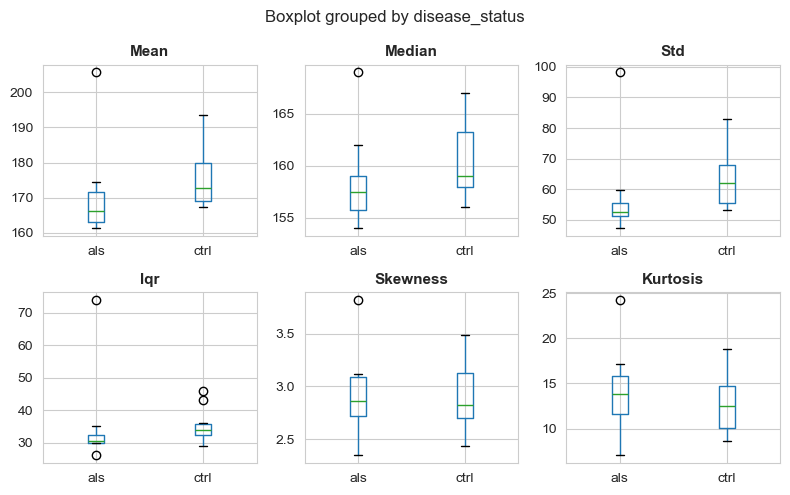

In [7]:
print("Fragment Size Features Summary:")
print("=" * 70)

# Get fragment size feature columns (exclude categories)
frag_size_cols = [c for c in fragmentomics_df.columns 
                 if c.startswith('frag_') and 'pct' not in c 
                 and c not in ['frag_ratio_short_long', 'frag_ratio_mono_di', 'frag_cv']]

# Display summary statistics
print(fragmentomics_df[frag_size_cols].describe().T.round(2))

# Visualize key features
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
fig.suptitle('Fragment Size Features: ALS vs Control', fontsize=14, fontweight='bold')

key_features = ['frag_mean', 'frag_median', 'frag_std', 'frag_iqr', 'frag_skewness', 'frag_kurtosis']

for idx, feat in enumerate(key_features):
    ax = axes[idx // 3, idx % 3]
    
    # Box plot
    fragmentomics_df.boxplot(column=feat, by='disease_status', ax=ax)
    ax.set_title(feat.replace('frag_', '').replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.sca(ax)
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Fragment Size Categories:

Mean percentage in each category:
disease_status              als   ctrl
frag_pct_very_short        2.52   2.27
frag_pct_short            31.90  28.68
frag_pct_mononucleosomal  55.54  56.73
frag_pct_dinucleosomal     9.06  10.99
frag_pct_long              0.98   1.33


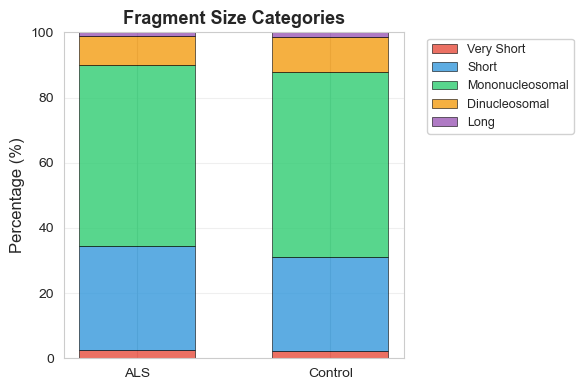



Statistical Tests (ALS vs Control):
Very Short          : p = 0.5752 
Short               : p = 0.1985 
Mononucleosomal     : p = 0.4887 
Dinucleosomal       : p = 0.0518 
Long                : p = 0.0134 *


In [9]:
print("Fragment Size Categories:")
print("=" * 70)

cat_cols = [c for c in fragmentomics_df.columns if c.startswith('frag_pct_')]

# Summary by disease status
print("\nMean percentage in each category:")
print(fragmentomics_df.groupby('disease_status')[cat_cols].mean().T.round(2))

# Visualize
fig, ax = plt.subplots(figsize=(6, 4))

# Prepare data
categories = [c.replace('frag_pct_', '').replace('_', ' ').title() for c in cat_cols]
als_means = fragmentomics_df[fragmentomics_df['disease_status'] == 'als'][cat_cols].mean().values
ctrl_means = fragmentomics_df[fragmentomics_df['disease_status'] == 'ctrl'][cat_cols].mean().values

# Stacked bar chart
x = ['ALS', 'Control']
width = 0.6

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

bottom_als = 0
bottom_ctrl = 0

for i, (cat, color) in enumerate(zip(categories, colors)):
    ax.bar(0, als_means[i], width, bottom=bottom_als, 
          color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.bar(1, ctrl_means[i], width, bottom=bottom_ctrl, 
          color=color, alpha=0.8, label=cat, edgecolor='black', linewidth=0.5)
    
    bottom_als += als_means[i]
    bottom_ctrl += ctrl_means[i]

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Fragment Size Categories', fontsize=13, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_xticklabels(x)
ax.set_ylim([0, 100])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical tests
from scipy.stats import mannwhitneyu

print("\n\nStatistical Tests (ALS vs Control):")
print("=" * 70)
for col in cat_cols:
    als_vals = fragmentomics_df[fragmentomics_df['disease_status'] == 'als'][col]
    ctrl_vals = fragmentomics_df[fragmentomics_df['disease_status'] == 'ctrl'][col]
    
    stat, p_val = mannwhitneyu(als_vals, ctrl_vals)
    
    cat_name = col.replace('frag_pct_', '').replace('_', ' ').title()
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
    print(f"{cat_name:20s}: p = {p_val:.4f} {sig}")

K-mer Distribution Analysis (ALL 256 4-mers):

Total k-mers extracted: 256

Top 10 most frequent 4-mers (mean % across samples):
   1. TTTT  : 5.372%
   2. AAAA  : 3.927%
   3. ATTT  : 2.943%
   4. TTTA  : 2.893%
   5. AAAT  : 2.786%
   6. TATT  : 2.589%
   7. TAAA  : 2.390%
   8. TTAT  : 2.386%
   9. AATT  : 2.320%
  10. AATA  : 2.286%

Top 10 least frequent 4-mers:
   1. CTTG  : 0.001%
   2. CTGG  : 0.001%
   3. GCAG  : 0.001%
   4. CTAG  : 0.001%
   5. CAGG  : 0.001%
   6. CTGC  : 0.001%
   7. GCCG  : 0.001%
   8. CCTG  : 0.001%
   9. GCTG  : 0.001%
  10. CCGG  : 0.000%


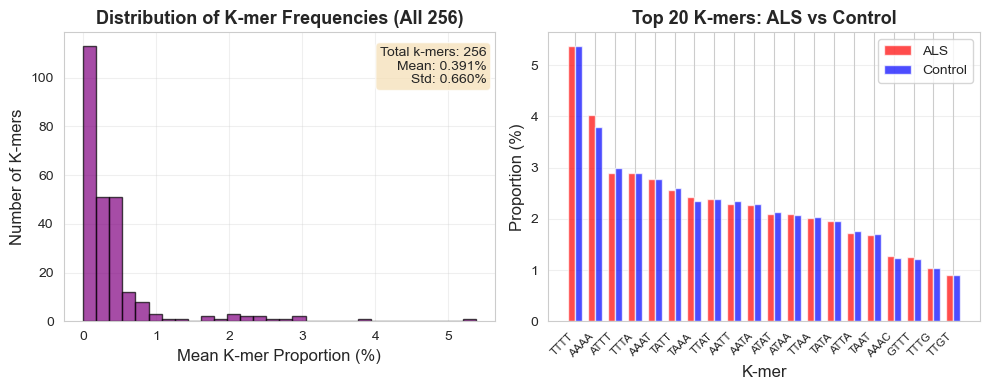

In [11]:
print("K-mer Distribution Analysis (ALL 256 4-mers):")
print("=" * 70)

# Get all k-mer columns
kmer_cols = [c for c in all_features_df.columns if c.startswith('kmer_')]

print(f"\nTotal k-mers extracted: {len(kmer_cols)}")

# Top 10 most frequent k-mers (averaged across all samples)
kmer_means = all_features_df[kmer_cols].mean().sort_values(ascending=False)

print(f"\nTop 10 most frequent 4-mers (mean % across samples):")
for i, (kmer, freq) in enumerate(kmer_means.head(10).items(), 1):
    kmer_seq = kmer.replace('kmer_', '')
    print(f"  {i:2d}. {kmer_seq:6s}: {freq:.3f}%")

print(f"\nTop 10 least frequent 4-mers:")
for i, (kmer, freq) in enumerate(kmer_means.tail(10).items(), 1):
    kmer_seq = kmer.replace('kmer_', '')
    print(f"  {i:2d}. {kmer_seq:6s}: {freq:.3f}%")

# Visualize k-mer distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Histogram of k-mer frequencies
ax = axes[0]
ax.hist(kmer_means.values, bins=30, edgecolor='black', alpha=0.7, color='purple')
ax.set_xlabel('Mean K-mer Proportion (%)', fontsize=12)
ax.set_ylabel('Number of K-mers', fontsize=12)
ax.set_title('Distribution of K-mer Frequencies (All 256)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add statistics
ax.text(0.98, 0.95, f'Total k-mers: {len(kmer_cols)}\nMean: {kmer_means.mean():.3f}%\nStd: {kmer_means.std():.3f}%',
       transform=ax.transAxes, fontsize=10, va='top', ha='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Top 20 k-mers comparison (ALS vs Control)
ax = axes[1]

top_20_kmers = kmer_means.head(20).index.tolist()

als_means_top20 = all_features_df[all_features_df['disease_status'] == 'als'][top_20_kmers].mean()
ctrl_means_top20 = all_features_df[all_features_df['disease_status'] == 'ctrl'][top_20_kmers].mean()

x = np.arange(20)
width = 0.35

# Clean k-mer names for display
kmer_names = [k.replace('kmer_', '') for k in top_20_kmers]

ax.bar(x - width/2, als_means_top20.values, width, label='ALS', color='red', alpha=0.7)
ax.bar(x + width/2, ctrl_means_top20.values, width, label='Control', color='blue', alpha=0.7)

ax.set_xlabel('K-mer', fontsize=12)
ax.set_ylabel('Proportion (%)', fontsize=12)
ax.set_title('Top 20 K-mers: ALS vs Control', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(kmer_names, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [12]:
print("K-mer Differential Analysis (ALS vs Control):")
print("=" * 70)

from scipy.stats import mannwhitneyu

# Test all 256 k-mers
kmer_results = []

for kmer in kmer_cols:
    als_vals = all_features_df[all_features_df['disease_status'] == 'als'][kmer]
    ctrl_vals = all_features_df[all_features_df['disease_status'] == 'ctrl'][kmer]
    
    stat, p_val = mannwhitneyu(als_vals, ctrl_vals)
    
    kmer_results.append({
        'kmer': kmer.replace('kmer_', ''),
        'p_value': p_val,
        'als_mean': als_vals.mean(),
        'ctrl_mean': ctrl_vals.mean(),
        'diff': als_vals.mean() - ctrl_vals.mean()
    })

kmer_results_df = pd.DataFrame(kmer_results).sort_values('p_value')

# Count significant k-mers
n_sig_05 = (kmer_results_df['p_value'] < 0.05).sum()
n_sig_01 = (kmer_results_df['p_value'] < 0.01).sum()

print(f"\nSignificant k-mers:")
print(f"  p < 0.05: {n_sig_05} / 256 ({n_sig_05/256*100:.1f}%)")
print(f"  p < 0.01: {n_sig_01} / 256 ({n_sig_01/256*100:.1f}%)")

if n_sig_05 > 0:
    print(f"\nTop 10 most significant k-mers:")
    print(kmer_results_df.head(10).to_string(index=False))
else:
    print(f"\nNo k-mers show significance at p < 0.05")
    print(f"(Expected with small sample size - Module 4 will investigate further)")
    print(f"\nTop 10 k-mers by lowest p-value:")
    print(kmer_results_df.head(10).to_string(index=False))

K-mer Differential Analysis (ALS vs Control):

Significant k-mers:
  p < 0.05: 6 / 256 (2.3%)
  p < 0.01: 0 / 256 (0.0%)

Top 10 most significant k-mers:
kmer  p_value  als_mean  ctrl_mean      diff
TCGA 0.013411  0.081714   0.092753 -0.011038
GTCT 0.027180  0.012967   0.018482 -0.005516
GCGG 0.032114  0.027096   0.021279  0.005817
CTAT 0.037797  0.462654   0.437270  0.025384
GGTG 0.044314  0.199331   0.184593  0.014738
CACT 0.044314  0.285852   0.306057 -0.020205
AAGG 0.051754  0.241909   0.254565 -0.012657
TCTT 0.051754  0.435533   0.470317 -0.034784
TTTC 0.051754  0.756114   0.825336 -0.069222
ATTG 0.060213  0.442590   0.459756 -0.017166


In [13]:
print("Coverage Profile:")
print("=" * 70)

# Get coverage bins (exclude metadata)
coverage_cols = [c for c in fragmentomics_df.columns 
                if c.startswith('coverage_bin_') 
                and c != 'coverage_bin_size']

print(f"Number of coverage bins: {len(coverage_cols)}")

# Check coverage values
coverage_data = fragmentomics_df[coverage_cols]

print(f"\nCoverage statistics:")
print(f"  Min: {coverage_data.min().min():.4f}%")
print(f"  Max: {coverage_data.max().max():.4f}%")
print(f"  Mean: {coverage_data.mean().mean():.4f}%")
print(f"  Std: {coverage_data.std().mean():.4f}%")

print(f"\nNote: Coverage profile plots are in Module 3 (Required Plots)")

Coverage Profile:
Number of coverage bins: 468

Coverage statistics:
  Min: 0.0000%
  Max: 0.9137%
  Mean: 0.2137%
  Std: 0.0203%

Note: Coverage profile plots are in Module 3 (Required Plots)


## Methylation Features Analysis

Global Methylation Features:
                       count        mean        std         min         25%  \
meth_total_cpg_sites    22.0  85780.7273  4471.6353  72961.0000  84079.2500   
meth_mean_cpg           22.0      0.8191     0.0093      0.8045      0.8115   
meth_std                22.0      0.3681     0.0086      0.3561      0.3625   
meth_cv                 22.0      0.4496     0.0151      0.4268      0.4395   
meth_pct_high           22.0     77.1155     1.3476     75.0124     75.8976   
meth_pct_low            22.0     15.5779     0.9910     14.1760     14.8837   
meth_pct_intermediate   22.0      7.3066     0.4845      6.1655      6.9654   

                              50%         75%         max  
meth_total_cpg_sites   86618.0000  88241.5000  93376.0000  
meth_mean_cpg              0.8218      0.8247      0.8360  
meth_std                   0.3656      0.3753      0.3822  
meth_cv                    0.4454      0.4621      0.4742  
meth_pct_high             77.5343     

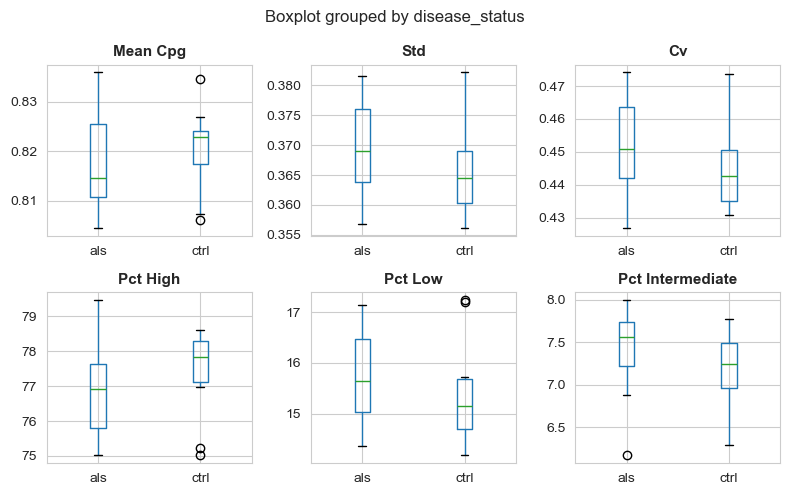



Global Methylation: ALS vs Control

meth_mean_cpg:
  ALS: 0.8178 ± 0.0100
  Control: 0.8206 ± 0.0086
  p-value: 0.6209 

meth_std:
  ALS: 0.3694 ± 0.0082
  Control: 0.3666 ± 0.0091
  p-value: 0.5310 

meth_cv:
  ALS: 0.4518 ± 0.0151
  Control: 0.4469 ± 0.0154
  p-value: 0.4887 

meth_pct_high:
  ALS: 76.8765 ± 1.4018
  Control: 77.4024 ± 1.2915
  p-value: 0.2766 

meth_pct_low:
  ALS: 15.7173 ± 0.9420
  Control: 15.4105 ± 1.0723
  p-value: 0.4887 

meth_pct_intermediate:
  ALS: 7.4062 ± 0.5227
  Control: 7.1872 ± 0.4298
  p-value: 0.2225 


In [16]:
print("Global Methylation Features:")
print("=" * 70)

# Get global methylation columns
global_meth_cols = [c for c in methylation_df.columns 
                   if c.startswith('meth_') and 'regional' not in c]

# Display summary
print(methylation_df[global_meth_cols].describe().T.round(4))

# Visualize key features
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
fig.suptitle('Global Methylation Features: ALS vs Control', fontsize=14, fontweight='bold')

key_meth_features = ['meth_mean_cpg', 'meth_std', 'meth_cv', 
                     'meth_pct_high', 'meth_pct_low', 'meth_pct_intermediate']

for idx, feat in enumerate(key_meth_features):
    ax = axes[idx // 3, idx % 3]
    if feat in methylation_df.columns:
        methylation_df.boxplot(column=feat, by='disease_status', ax=ax)
        ax.set_title(feat.replace('meth_', '').replace('_', ' ').title(), 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
        plt.sca(ax)
        plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Statistical tests
from scipy.stats import mannwhitneyu

print("\n\nGlobal Methylation: ALS vs Control")
print("=" * 70)

for feat in key_meth_features:
    if feat in methylation_df.columns:
        als_vals = methylation_df[methylation_df['disease_status'] == 'als'][feat].dropna()
        ctrl_vals = methylation_df[methylation_df['disease_status'] == 'ctrl'][feat].dropna()
        
        if len(als_vals) > 0 and len(ctrl_vals) > 0:
            stat, p_val = mannwhitneyu(als_vals, ctrl_vals)
            
            print(f"\n{feat}:")
            print(f"  ALS: {als_vals.mean():.4f} ± {als_vals.std():.4f}")
            print(f"  Control: {ctrl_vals.mean():.4f} ± {ctrl_vals.std():.4f}")
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"  p-value: {p_val:.4f} {sig}")

Regional Methylation Coverage:

Total methylation bins: 468

Bins with data per sample (≥20 CpG sites):
count     22.000000
mean     362.090909
std        1.900103
min      358.000000
25%      361.250000
50%      362.000000
75%      363.000000
max      366.000000
Name: regional_meth_n_bins_with_data, dtype: float64

Coverage percentage:
count    22.000000
mean     77.369852
std       0.406005
min      76.495726
25%      77.190171
50%      77.350427
75%      77.564103
max      78.205128
Name: regional_coverage_pct, dtype: float64


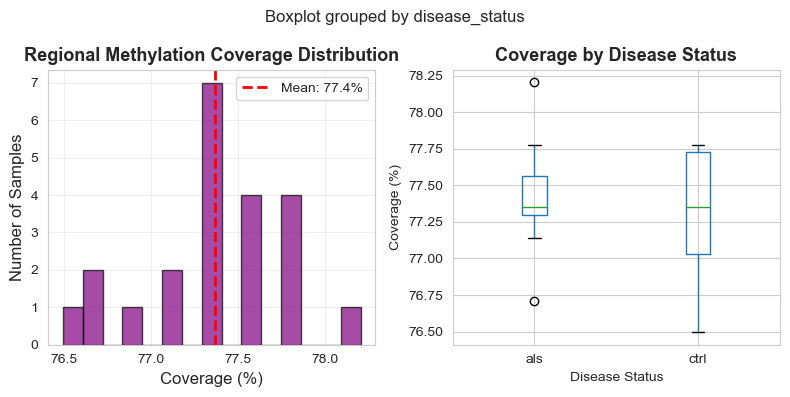


Coverage by disease status:
  ALS: 77.4% ± 0.4%
  Control: 77.3% ± 0.5%
  p-value: 0.8397

✓ Coverage is balanced between groups (p > 0.05)


In [19]:
print("Regional Methylation Coverage:")
print("=" * 70)

if 'regional_meth_n_bins_with_data' in methylation_df.columns:
    # Get expected number of bins
    n_bins = methylation_df['regional_meth_n_bins'].iloc[0] if 'regional_meth_n_bins' in methylation_df.columns else n_meth_bins
    
    # Summary statistics
    print(f"\nTotal methylation bins: {n_bins}")
    print(f"\nBins with data per sample (≥{MIN_CPG_PER_BIN} CpG sites):")
    print(methylation_df['regional_meth_n_bins_with_data'].describe())
    
    # Calculate coverage percentage
    methylation_df['regional_coverage_pct'] = (methylation_df['regional_meth_n_bins_with_data'] / n_bins) * 100
    
    print(f"\nCoverage percentage:")
    print(methylation_df['regional_coverage_pct'].describe())
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Coverage distribution
    ax = axes[0]
    methylation_df['regional_coverage_pct'].hist(bins=15, ax=ax, edgecolor='black', alpha=0.7, color='purple')
    ax.axvline(methylation_df['regional_coverage_pct'].mean(), color='red', linestyle='--', 
              linewidth=2, label=f'Mean: {methylation_df["regional_coverage_pct"].mean():.1f}%')
    ax.set_xlabel('Coverage (%)', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Regional Methylation Coverage Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Coverage by disease
    ax = axes[1]
    methylation_df.boxplot(column='regional_coverage_pct', by='disease_status', ax=ax)
    ax.set_title('Coverage by Disease Status', fontsize=13, fontweight='bold')
    ax.set_xlabel('Disease Status')
    ax.set_ylabel('Coverage (%)')
    plt.sca(ax)
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Test for coverage differences
    from scipy.stats import mannwhitneyu
    
    als_cov = methylation_df[methylation_df['disease_status'] == 'als']['regional_coverage_pct']
    ctrl_cov = methylation_df[methylation_df['disease_status'] == 'ctrl']['regional_coverage_pct']
    
    stat, p_val = mannwhitneyu(als_cov, ctrl_cov)
    
    print(f"\nCoverage by disease status:")
    print(f"  ALS: {als_cov.mean():.1f}% ± {als_cov.std():.1f}%")
    print(f"  Control: {ctrl_cov.mean():.1f}% ± {ctrl_cov.std():.1f}%")
    print(f"  p-value: {p_val:.4f}")
    
    if p_val > 0.05:
        print("\n✓ Coverage is balanced between groups (p > 0.05)")
    else:
        print("\n⚠️ Coverage differs between groups")

Regional Methylation Profile (ALL Discovery Samples with Sample IDs):
Number of regional methylation bins: 469

Discovery samples: 8
  ALS: 4
  Control: 4


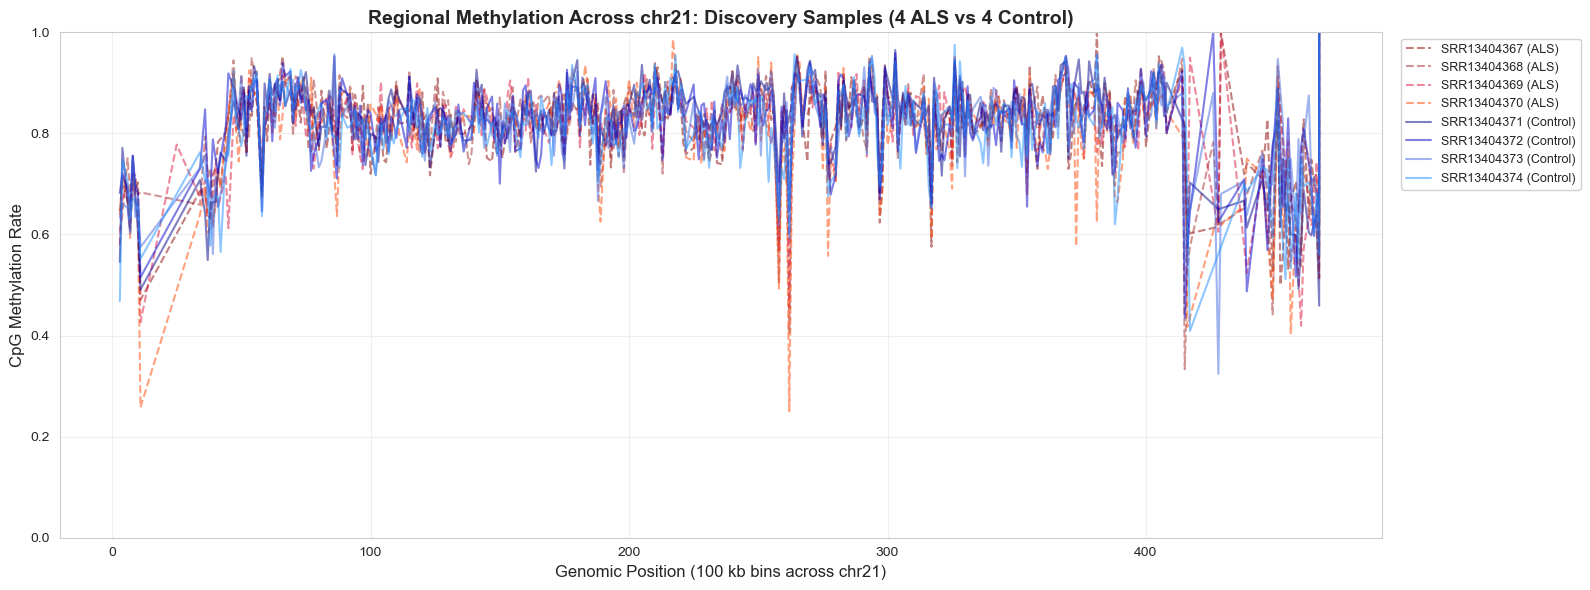


Coverage Statistics (Discovery Samples):

Per-sample coverage:
  SRR13404367     (ALS    ):  77.6% (364/469 bins)
  SRR13404368     (ALS    ):  77.4% (363/469 bins)
  SRR13404369     (ALS    ):  77.2% (362/469 bins)
  SRR13404370     (ALS    ):  77.8% (365/469 bins)
  SRR13404371     (CTRL   ):  77.4% (363/469 bins)
  SRR13404372     (CTRL   ):  77.4% (363/469 bins)
  SRR13404373     (CTRL   ):  77.8% (365/469 bins)
  SRR13404374     (CTRL   ):  77.4% (363/469 bins)

Interpretation:
  - Each line = one discovery sample's methylation profile
  - Red = ALS (4 samples in different shades, dashed lines)
  - Blue = Control (4 samples in different shades, solid lines)


In [28]:
print("Regional Methylation Profile (ALL Discovery Samples with Sample IDs):")
print("=" * 70)

# Get regional methylation bins
regional_meth_cols = sorted([c for c in methylation_df.columns 
                             if c.startswith('regional_meth_bin_')])

print(f"Number of regional methylation bins: {len(regional_meth_cols)}")

# Filter to discovery samples only
discovery_samples = methylation_df[methylation_df['batch'] == 'discovery'].copy()

print(f"\nDiscovery samples: {len(discovery_samples)}")
print(f"  ALS: {len(discovery_samples[discovery_samples['disease_status'] == 'als'])}")
print(f"  Control: {len(discovery_samples[discovery_samples['disease_status'] == 'ctrl'])}")

# Create figure
fig, ax = plt.subplots(figsize=(16, 6))

# Color palettes
als_colors = ['#8B0000', '#A52A2A', '#DC143C', '#FF4500']  # Dark red shades
ctrl_colors = ['#00008B', '#0000CD', '#4169E1', '#1E90FF']  # Dark blue shades

# Plot ALS samples (see through, dashed lines)
als_samples = discovery_samples[discovery_samples['disease_status'] == 'als']
for idx, (_, sample) in enumerate(als_samples.iterrows()):
    sample_id = sample['sample_id']

    # Convert to numeric
    meth_values = pd.to_numeric(sample[regional_meth_cols], errors='coerce').values

    # Get valid (non-NaN) values
    valid_mask = ~np.isnan(meth_values)
    valid_indices = np.where(valid_mask)[0]
    valid_values = meth_values[valid_mask]

    # Plot with shade of red; semi-transparent (alpha=0.5), dashed lines
    color = als_colors[idx % len(als_colors)]
    ax.plot(valid_indices, valid_values, 
           linewidth=1.5, alpha=0.5, color=color, linestyle='--',
           label=f'{sample_id} (ALS)')

# Plot Control samples (see through, solid line)
ctrl_samples = discovery_samples[discovery_samples['disease_status'] == 'ctrl']
for idx, (_, sample) in enumerate(ctrl_samples.iterrows()):
    sample_id = sample['sample_id']

    # Convert to numeric
    meth_values = pd.to_numeric(sample[regional_meth_cols], errors='coerce').values

    # Get valid (non-NaN) values
    valid_mask = ~np.isnan(meth_values)
    valid_indices = np.where(valid_mask)[0]
    valid_values = meth_values[valid_mask]

    # Plot with shade of blue; semi-transparent (alpha=0.5), solid lines
    color = ctrl_colors[idx % len(ctrl_colors)]
    ax.plot(valid_indices, valid_values, 
           linewidth=1.5, alpha=0.5, color=color, linestyle='-',
           label=f'{sample_id} (Control)')

ax.set_xlabel('Genomic Position (100 kb bins across chr21)', fontsize=12)
ax.set_ylabel('CpG Methylation Rate', fontsize=12)
ax.set_title('Regional Methylation Across chr21: Discovery Samples (4 ALS vs 4 Control)', 
            fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Legend
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.show()

# Calculate and display coverage statistics
print("\nCoverage Statistics (Discovery Samples):")
print("=" * 70)

print(f"\nPer-sample coverage:")
for _, sample in discovery_samples.iterrows():
    sample_id = sample['sample_id']
    disease = sample['disease_status'].upper()

    meth_values = pd.to_numeric(sample[regional_meth_cols], errors='coerce').values
    n_valid = np.sum(~np.isnan(meth_values))
    coverage_pct = (n_valid / len(regional_meth_cols)) * 100

    print(f"  {sample_id:15s} ({disease:7s}): {coverage_pct:5.1f}% ({n_valid}/{len(regional_meth_cols)} bins)")

print("\nInterpretation:")
print("  - Each line = one discovery sample's methylation profile")
print("  - Red = ALS (4 samples in different shades, dashed lines)")
print("  - Blue = Control (4 samples in different shades, solid lines)")

## Module 2 Summary

**Module 2 Complete!** ✓

---

### Features Extracted 

**Fragmentomics (~745 features):**
- Fragment size statistics: 20 features
- Fragment size categories: 5 features  
- **K-mer proportions: 256 features**
- Motif summary: 2 features
- Coverage profile (100 kb bins): 468 features

**Methylation (~475 features):**
- Global methylation: 8 features
- Regional methylation (100 kb bins): 467 features

**Total: ~1,220 features**

### Observations

**Fragment Size - Long Fragments (p = 0.0134)**
- ALS: 0.98% long fragments (>400 bp)
- Control: 1.33% long fragments
- Difference: 36% more long fragments in Control

**Fragment Size - Dinucleosomal (p = 0.0518, trend)**
- ALS: 9.06% dinucleosomal (220-400 bp)
- Control: 10.99% dinucleosomal
- Trend: Control has ~21% more dinucleosomal fragments

**K-mers - 6 Significant (p < 0.05)**
- TCGA (p = 0.013): Lower in ALS
- GTCT (p = 0.027): Lower in ALS
- GCGG (p = 0.032): Higher in ALS
- CTAT (p = 0.038): Higher in ALS
- GGTG (p = 0.044): Higher in ALS
- CACT (p = 0.044): Lower in ALS
